In [495]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [496]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
color = sns.color_palette()
from patsy import dmatrices
%matplotlib inline

In [497]:
train = pd.read_csv("~/Desktop/Benz/train.csv", index_col =0)
test = pd.read_csv("~/Desktop/Benz/test.csv", index_col=0)
df = train.append(test)
train_X = train.drop('y', axis=1)

A couple of linear-based regression models have been tested and Lasso shows the highest R-Squared.

| Algorithms | R-squared   |
|------|-------------|
| OLS  | 0.506|
| Duplicated Predictors Removal  | 0.528|
| PCA  | 0.533|
| PSL  | 0.310|
| Lasso  | 0.546|
|PCA+Lasso | 0.533|

# Data processing

Numeric predictors

In [498]:
num_predictors = train_X.dtypes[train_X.dtypes!='object']
num_predictors = num_predictors.index.values

Features that have only one level of values bring no information for regression and should be removed

In [499]:
zero_predictors = []
for i in num_predictors:
    if len(train_X[i].unique()) !=2:
        zero_predictors.append(i)

In [500]:
zero_predictors

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

In [501]:
df = df.drop(zero_predictors, axis = 1)

In [502]:
num_predictors = [x for x in num_predictors if x not in zero_predictors]

## Remove near-zero & co-related predictors

A rule of thumb for detecting near-zero variance predictors is:
1. The fraction of unique values over the sample size is low (say 10 %).
2. The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20).”

Excerpt From: Max Kuhn and Kjell Johnson. “Applied Predictive Modeling.” iBooks. 

So I removed those predictors whose percentage of 1 are above 0.9 or below 0.1.

In [266]:
one_percentage = df[num_predictors].T.sum(axis=1)/len(train)
near_zero_predictors = one_percentage[(one_percentage >=0.9) | (one_percentage <= 0.1)].index.values

In [267]:
df = df.drop(near_zero_predictors, axis = 1)

In [268]:
num_predictors = [x for x in num_predictors if x not in near_zero_predictors]

Missing values: no missing values in this dataset. Good!

In [269]:
df.columns[df.isnull().sum()!=0]

Index([u'y'], dtype='object')

Correlation between predictors. It can be seen that numerous pairs of predictors are highly positively or negatively related. 

An algorithm to remove correlated predictors:

1.
Calculate the correlation matrix of the predictors.
 
2.
Determine the two predictors associated with the largest absolute pairwise correlation (call them predictors A and B).
 
3.
Determine the average correlation between A and the other variables. Do the same for predictor B.
 
4.
If A has a larger average correlation, remove it; otherwise, remove predictor B.
 
5.
Repeat Steps 2–4 until no absolute correlations are above the threshold”

Excerpt From: Max Kuhn and Kjell Johnson. “Applied Predictive Modeling.” iBooks. 

In this dataset, I set the 0.7 as the threshold. After running the algorithm, the number of columns has been deducted to 47.

In [270]:
def find_max(df_c):
    max_ = 0
    max_i = 0
    max_j = 0
    for i in range(len(df_c.columns)):
        for j in range(i+1, len(df_c.columns)):
            if abs(df_c.iloc[i, j]) > max_:
                max_i = i
                max_j = j
                max_ = abs(df_c.iloc[i, j])
    return max_i, max_j, max_

In [271]:
corr_df = df[num_predictors]
corr = corr_df.corr()
drop_list = []
while True:
    c1, c2, cor = find_max(corr)
    if cor < 0.7:
        break
    else:
        if corr.iloc[c1].mean() > corr.iloc[c2].mean():
            corr_df = corr_df.drop(corr.columns[c1], axis=1)
            drop_list.append(corr.columns[c1])
        else:
            corr_df = corr_df.drop(corr.columns[c2], axis=1)
            drop_list.append(corr.columns[c2])
        corr = corr_df.corr()

In [272]:
df = df.drop(drop_list, axis =1)

## PCA

In [503]:
from sklearn.decomposition import PCA

In [504]:
df = pd.get_dummies(df)

In [505]:
pca = PCA(n_components=len(df.columns)-1)
pca.fit(df.drop('y', axis=1))

PCA(copy=True, iterated_power='auto', n_components=567, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

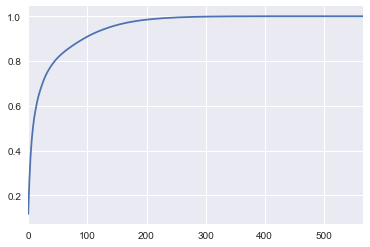

In [325]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot()

In [361]:
scores =[]
for i in range(30,250, 2):
    pca = PCA(n_components = i)
    df_set = pd.DataFrame(pca.fit_transform(df.drop('y', axis=1)))
    train_set = df_set[:4209]
    train_set['y'] = train['y'].reset_index()['y']
    #test_set = df_set[4209:]
    scores.append(test(train_set))

/Users/bruceso/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Choosing different numbers of principal components, seems the best to generate a high validation and keeps the model simple.

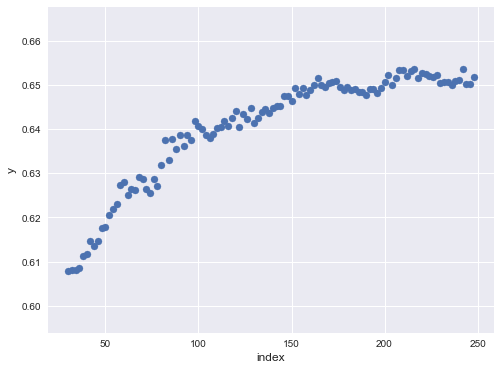

In [363]:
plt.figure(figsize=(8,6))
plt.scatter(range(30,250,2), scores)
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [506]:
#Submit PCA
pca = PCA(n_components = 175)
df_set = pd.DataFrame(pca.fit_transform(df.drop('y', axis=1)))

In [378]:
submit(df_set, train.y)

## PLS

In [379]:
from sklearn.cross_decomposition import PLSRegression

In [414]:
x = pd.get_dummies(df[df['y'].notnull()])
x = x[x['y']<130]

In [438]:
scores=[]
for i in range(20, 250, 2):
    pls = PLSRegression(n_components=i)
    train_set, train_y = pls.fit_transform(X = x.drop('y', axis=1), y=x.y)
    X_train, X_test, y_train, y_test = train_test_split(train_set, train_y,
                                                        test_size=0.3, random_state=916)
    
    pls.fit(X_train, y_train)
    
    preds = pls.predict(X_test)
    preds_ = []
    for j in range(len(preds)):
        preds_.append(preds[j][0])
    preds_ = pd.Series(preds_)
    preds_[preds_>200]=100
    preds_[preds_<-200]=100
    
    scores.append(r2_score(y_test, preds_))

/Users/bruceso/anaconda/lib/python2.7/site-packages/sklearn/cross_decomposition/pls_.py:316: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


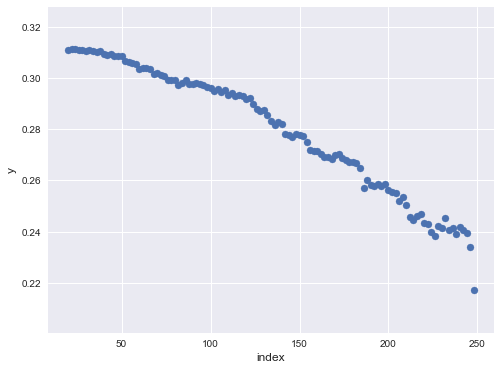

In [441]:
plt.figure(figsize=(8,6))
plt.scatter(range(20, 250, 2), scores)
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

## Lasso

In [444]:
from sklearn import linear_model
x = pd.get_dummies(df[df['y'].notnull()])
x = x[x['y']<130]
X_train, X_test, y_train, y_test = train_test_split(x.drop('y', axis=1), x.y,
                                                    test_size=0.3, random_state=916)

In [459]:
scores = []
l = np.arange(0.001, 0.007, 0.001)
for i in l:
    clf = linear_model.Lasso(alpha=i, normalize = True)
    clf.fit(X_train, y_train)
    preds = pd.Series(clf.predict(X_test))
    scores.append(r2_score(y_test, preds))

/Users/bruceso/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


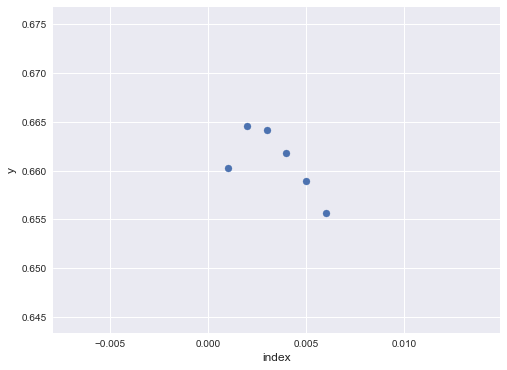

In [463]:
plt.figure(figsize=(8,6))
plt.scatter(l, scores)
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [476]:
df = pd.get_dummies(df)
t1 = df[df.y.notnull()]
t2 = df[df.y.isnull()]

In [478]:
clf = linear_model.Lasso(alpha=0.002, normalize = True)
clf.fit(t1.drop('y', axis=1), t1.y)
preds = pd.Series(clf.predict(t2.drop('y', axis=1)))

In [482]:
sub = pd.DataFrame()
test = pd.read_csv("~/Desktop/Benz/test.csv", index_col=0)
sub['ID'] = test.index
sub['y'] = preds
sub.to_csv("~/Desktop/Benz/Benz.csv", index=False)

## Lasso + PCA

In [512]:
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(df_set[:4209], train.y,
                                                    test_size=0.3, random_state=916)

In [517]:
scores = []
l = np.arange(0.001, 0.01, 0.0005)
for i in l:
    clf = linear_model.Lasso(alpha=i, normalize = True)
    clf.fit(X_train, y_train)
    preds = pd.Series(clf.predict(X_test))
    scores.append(r2_score(y_test, preds))

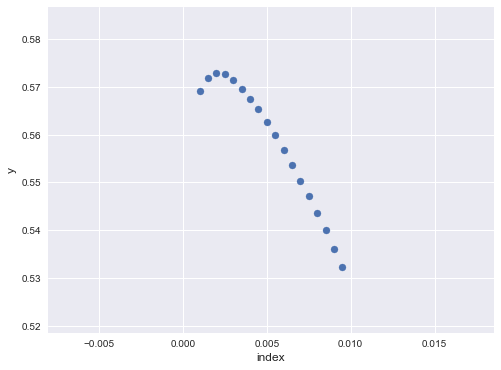

In [518]:
plt.figure(figsize=(8,6))
plt.scatter(l, scores)
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [521]:
clf = linear_model.Lasso(alpha=0.002, normalize = True)
clf.fit(df_set[:4209], train.y)
preds = pd.Series(clf.predict(df_set[4209:]))

In [522]:
test = pd.read_csv("~/Desktop/Benz/test.csv", index_col=0)
sub['ID'] = test.index
sub['y'] = preds
sub.to_csv("~/Desktop/Benz/Benz.csv", index=False)

## Commonly used functions

In [343]:
from sklearn.model_selection import train_test_split
def test(df):
    x = df
    x = x[x['y']<130]
    X_train, X_test, y_train, y_test = train_test_split(x.drop('y', axis=1), x['y'], test_size=0.3, random_state=916)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = pd.Series(lr.predict(X_test))
    preds[preds>200]=100
    preds[preds<-200]=100
    return r2_score(y_test, preds)

In [307]:
def cv_test(df):
    #CV
    kf = KFold(n_splits=10, random_state=10, shuffle=True)
    lr = LinearRegression()
    scores = []
    for train_index, test_index in kf.split(x):
        train_X = x.drop('y', axis=1).iloc[train_index]
        train_y = train.iloc[train_index]['y']
        test_X = x.drop('y', axis=1).iloc[test_index]
        test_y = train.iloc[test_index]['y']
        lr.fit(train_X, train_y)
        preds = lr.predict(test_X)
        preds[preds>200]=100
        preds[preds<-200]=100
        scores.append(r2_score(test_y, preds))
    print scores

In [308]:
test(df)
cv_test(df)

0.641256742584
[-0.088804075668576843, -0.064815466642451858, -0.082348343012990766, -0.056973611609113739, -0.028640298747840243, -0.11340716840307286, -0.033040488453762729, -0.048203962798018196, -0.086273464190953941, -0.054782864659577823]


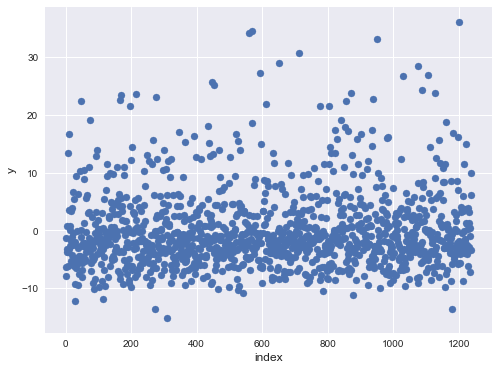

In [275]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(preds)), y_test.reset_index()['y'] - preds)
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [377]:
def submit(df, y):
    df_set = pd.get_dummies(df)
    train_set = df_set[:4209]
    test_set = df_set[4209:]

    lr.fit(train_set, y)
    preds = pd.Series(lr.predict(test_set))
    preds[preds>200]=100
    preds[preds<-200]=100
    sub = pd.DataFrame()
    test = pd.read_csv("~/Desktop/Benz/test.csv", index_col=0)
    sub['ID'] = test.index
    sub['y'] = preds
    sub.to_csv("~/Desktop/Benz/Benz.csv", index=False)

In [491]:
df = pd.get_dummies(df)

In [494]:
submit(df.drop('y', axis=1), df[df.y.notnull()].y)